In [18]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score, recall_score, precision_score, accuracy_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE

# Data Ingestion

Data Souce: https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction/data

In [2]:
data = pd.read_csv('Data/train.csv')
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [3]:
data.shape

(381109, 12)

In [4]:
data['Response'].value_counts()

0    334399
1     46710
Name: Response, dtype: int64

# Data Processing

In [5]:
data = data.drop(columns=['id'],axis=1)

In [6]:
X = data.drop('Response', axis=1)
Y = data['Response']

### One-Hot Encoding

In [7]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]],drop_first = True)
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

features_to_encode = X.select_dtypes('object').columns.to_list()
for feature in features_to_encode:
    X = encode_and_bind(X, feature)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Age                    381109 non-null  int64  
 1   Driving_License        381109 non-null  int64  
 2   Region_Code            381109 non-null  float64
 3   Previously_Insured     381109 non-null  int64  
 4   Annual_Premium         381109 non-null  float64
 5   Policy_Sales_Channel   381109 non-null  float64
 6   Vintage                381109 non-null  int64  
 7   Gender_Male            381109 non-null  uint8  
 8   Vehicle_Age_< 1 Year   381109 non-null  uint8  
 9   Vehicle_Age_> 2 Years  381109 non-null  uint8  
 10  Vehicle_Damage_Yes     381109 non-null  uint8  
dtypes: float64(3), int64(4), uint8(4)
memory usage: 21.8 MB


In [8]:
X.head()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
0,44,1,28.0,0,40454.0,26.0,217,1,0,1,1
1,76,1,3.0,0,33536.0,26.0,183,1,0,0,0
2,47,1,28.0,0,38294.0,26.0,27,1,0,1,1
3,21,1,11.0,1,28619.0,152.0,203,1,1,0,0
4,29,1,41.0,1,27496.0,152.0,39,0,1,0,0


### Feature Selection

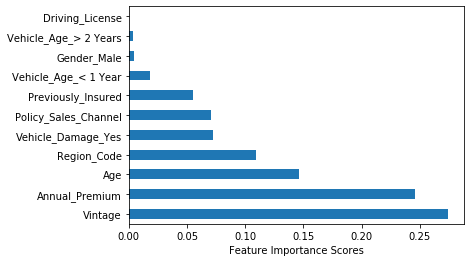

In [9]:
model = ExtraTreesClassifier(random_state=1).fit(X,Y)
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='barh')

plt.xlabel('Feature Importance Scores')
plt.savefig('feature_selection_matplotlib.jpeg',dpi=400, bbox_inches='tight')

In [10]:
importantFeatures = list(feature_importances.nlargest(7).index) # Top 7 important features
importantFeatures

['Vintage',
 'Annual_Premium',
 'Age',
 'Region_Code',
 'Vehicle_Damage_Yes',
 'Policy_Sales_Channel',
 'Previously_Insured']

In [11]:
X_final = X[importantFeatures]

### Imbalanced Data Processing

In [12]:
print(X_final.shape)
print(Y.shape)
print(Y.value_counts())

(381109, 7)
(381109,)
0    334399
1     46710
Name: Response, dtype: int64


In [13]:
over = SMOTE(sampling_strategy='auto', random_state=3)
X_train, y_train = over.fit_resample(X_final,Y)

In [14]:
print(X_train.shape)
print(y_train.shape)
print(y_train.value_counts())

(668798, 7)
(668798,)
1    334399
0    334399
Name: Response, dtype: int64


### Data Splitting

In [15]:
X_train_o, X_test, y_train_o, y_test = train_test_split(X_train, y_train, test_size= 0.3, random_state=3)

# Modeling

### Logistic Regression

In [16]:
logistic = LogisticRegression(solver='newton-cg')
logistic.fit(X_train_o, y_train_o)
log_pred = logistic.predict(X_test)

D:\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,


In [17]:
logistic_accuracy = accuracy_score(y_test,log_pred)
logistic_recall = recall_score(y_test,log_pred)
logistic_precision= precision_score(y_test,log_pred)
logistic_f1 = f1_score(y_test,log_pred)
logistic_auc = roc_auc_score(y_test, log_pred)

In [19]:
joblib.dump(logistic, 'LogisticRegression.pkl')

['LogisticRegression.pkl']

### AdaBoost

In [20]:
ada = AdaBoostClassifier(n_estimators= 100,learning_rate=0.05,random_state=3)
ada.fit(X_train_o,y_train_o)
ada_pred= ada.predict(X_test)

AdaBoost_accuracy = accuracy_score(y_test,ada_pred)
AdaBoost_recall = recall_score(y_test,ada_pred)
AdaBoost_precision= precision_score(y_test,ada_pred)
AdaBoost_f1 = f1_score(y_test,ada_pred)
AdaBoost_auc = roc_auc_score(y_test,ada_pred)

In [21]:
joblib.dump(ada, 'AdaBoost.pkl')

['AdaBoost.pkl']

### XGBoost

In [22]:
xgb = XGBClassifier().fit(X_train_o,y_train_o)
xgb_pred = xgb.predict(X_test)

XGBoost_accuracy = accuracy_score(y_test,xgb_pred)
XGBoost_recall = recall_score(y_test,xgb_pred)
XGBoost_precision = precision_score(y_test,xgb_pred)
XGBoost_f1 = f1_score(y_test,xgb_pred)
XGBoost_auc = roc_auc_score(y_test, xgb_pred) 

D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:51:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [23]:
joblib.dump(xgb, 'XGBoost.pkl')

['XGBoost.pkl']

# Results

In [24]:
results= pd.DataFrame()
results['Model'] = ['Logistic','AdaBoost','XGBoost']
results['Accuracy'] = [logistic_accuracy, AdaBoost_accuracy, XGBoost_accuracy]
results['Recall'] = [logistic_recall, AdaBoost_recall, XGBoost_recall]
results['Precision'] = [logistic_precision, AdaBoost_precision, XGBoost_precision]
results['F1'] = [logistic_f1, AdaBoost_f1, XGBoost_f1]
results['AUC'] = [logistic_auc, AdaBoost_auc, XGBoost_auc]

results

,Model,Accuracy,Recall,Precision,F1,AUC
0,Logistic,0.776181,0.962156,0.700915,0.811017,0.776498
1,AdaBoost,0.794004,0.949955,0.723717,0.821545,0.794270
2,XGBoost,0.889090,0.889575,0.888377,0.888975,0.889091


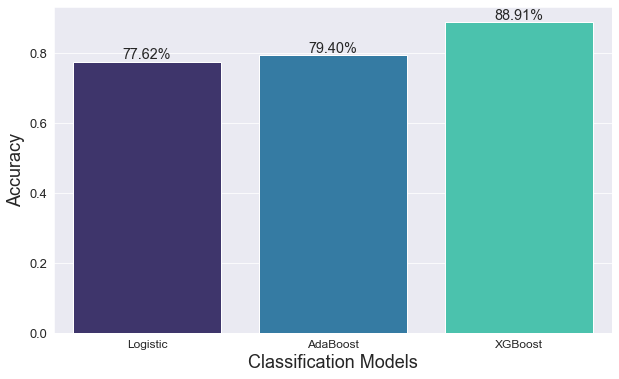

In [25]:
plt.rcParams['figure.figsize']=10,6 
sns.set_style("darkgrid")
ax = sns.barplot(x=results.Model, y=results.Accuracy, palette = "mako", saturation =1.5)
plt.xlabel("Classification Models", fontsize = 18)
plt.ylabel("Accuracy", fontsize = 18)
plt.xticks(fontsize = 12, horizontalalignment = 'center')
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*1.01), ha='center', fontsize = 'x-large')

plt.savefig('Accuracy.jpeg',dpi=400, bbox_inches='tight')

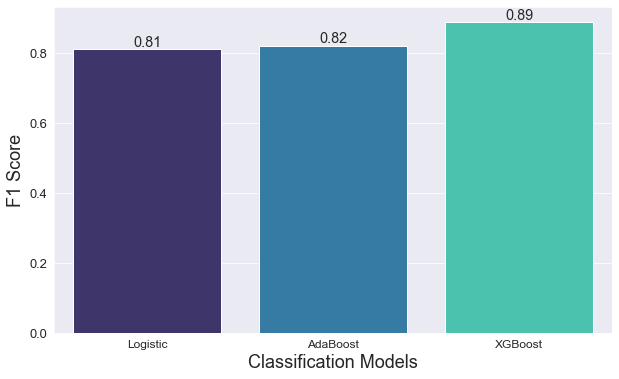

In [26]:
plt.rcParams['figure.figsize']=10,6 
sns.set_style("darkgrid")
ax = sns.barplot(x=results.Model, y=results.F1, palette = "mako", saturation =1.5)
plt.xlabel("Classification Models", fontsize = 18)
plt.ylabel("F1 Score", fontsize = 18)
plt.xticks(fontsize = 12, horizontalalignment = 'center')
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2}', (x + width/2, y + height*1.01), ha='center', fontsize = 'x-large')

plt.savefig('F1.jpeg',dpi=400, bbox_inches='tight')

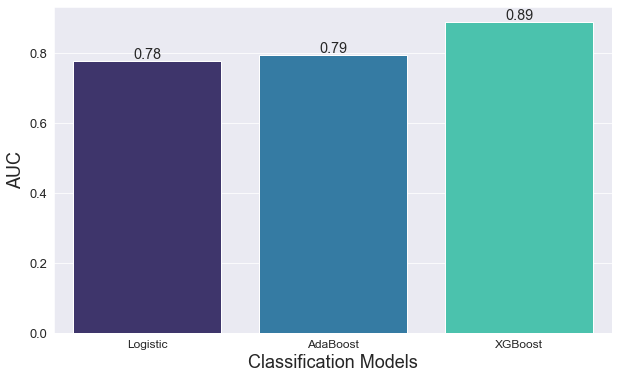

In [27]:
plt.rcParams['figure.figsize']=10,6 
sns.set_style("darkgrid")
ax = sns.barplot(x=results.Model, y=results.AUC, palette = "mako", saturation =1.5)
plt.xlabel("Classification Models", fontsize = 18)
plt.ylabel("AUC", fontsize = 18)
plt.xticks(fontsize = 12, horizontalalignment = 'center')
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2}', (x + width/2, y + height*1.01), ha='center', fontsize = 'x-large')

plt.savefig('AUC.jpeg',dpi=400, bbox_inches='tight')

# Conclusions

From the modeling results, it's clear to see that the XGBoost model achieved the highest accuracy, F1 score, and AUC among three classifiers. 

Therefore, the XGBoost classifier is the optimal model for predicting Health Insurance owners who will be interested in Vehicle Insurance.